# Import libraries and modules

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [ ]:
import sys, os
# add project root (parent folder of the notebook) to sys.path
sys.path.append(os.path.abspath(".."))
import os
from glob import glob
import json
from matplotlib import pyplot as plt
from causalDA.plotting import plot_graph, plot_links_graph_svg
from reproduce.utils.config import NODE_LOOKUP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import gaussian_kde

# Functions

In [4]:
# Count the simulation files
def count_completed_seeds(results_dir="results/eval/no_priority"):
    """
    Count completed simulation seeds based on existing tau result files.
    Args:
        results_dir (str): Directory containing simulation results.
    Returns:
        list: List of completed seed integers.
    """
    completed = []
    for path in glob(os.path.join(results_dir, "seed_*")):
        seed = int(os.path.basename(path).split("_")[1])
        tau_files = glob(os.path.join(path, "tau*.json"))
        if tau_files:  # at least one tau result exists
            completed.append(seed)
    return completed


In [5]:
def read_seed_results(seed, results_dir="results/eval/no_priority"):
    """
    Read evaluation results for a specific seed across all tau values.
    Args:
        seed (int): The random seed identifier.
        results_dir (str): Directory containing simulation results.
    Returns:
        dict: Dictionary mapping tau values to their corresponding results.
    """
    seed_dir = os.path.join(results_dir, f"seed_{seed:04d}")
    if not os.path.exists(seed_dir):
        raise FileNotFoundError(f"No results found for seed {seed}")   
    results = {}
    for path in glob(os.path.join(seed_dir, "tau*.json")):
        tau = int(os.path.basename(path).replace("tau", "").replace(".json", ""))
        try:
            with open(path, "r") as f:
                results[tau] = json.load(f)
        except json.JSONDecodeError as e:
            print(f"JSONDecodeError in file: {path}")
            raise e
        except Exception as e:
            print(f"Unexpected error in file: {path}")
            raise e
    return results

In [7]:
def build_metric_df(all_results, metric):
    """
    Build a DataFrame for a specific metric across all tau values.
    Args:
        all_results (dict): Dictionary mapping tau values to their corresponding results.
        metric (str): The metric to extract (e.g., "AUC", "FPR", "TPR").
    Returns:
        pd.DataFrame: DataFrame with columns "tau" and "value".
    """
    records = []
    taus = sorted(all_results.keys())

    for tau in taus:
        for value in all_results[tau][metric]:
            records.append({"tau": tau, "value": value})

    df = pd.DataFrame(records)
    return df

In [8]:
def plot_vertical_kde(df, metric="AUC", tau_step=2, tau_ref=None,
                      figsize=(25, 12), alpha=0.8, cmap=plt.cm.viridis,
                      axis_fontsize=22, tick_fontsize=18,
                      title_fontsize=26, legend_fontsize=20, title=True,
                      ax=None):
    """
    Plot vertical KDEs of a metric across different tau values.
    Args:
        df (pd.DataFrame): DataFrame with columns "tau" and "value".
        metric (str): The metric being plotted (for labeling purposes).
        tau_step (int): Step size for selecting tau values to plot.
        tau_ref (int or None): Reference tau value to highlight.
        figsize (tuple): Figure size.
        alpha (float): Transparency for the filled KDE areas.
        cmap (colormap): Colormap for different tau values.
        axis_fontsize (int): Font size for axis labels.
        tick_fontsize (int): Font size for tick labels.
        title_fontsize (int): Font size for the plot title.
        legend_fontsize (int): Font size for the legend.
        title (bool): Whether to display the title.
        ax (matplotlib.axes.Axes or None): Axes object to plot on. If None, a new figure and axes are created.
    Returns:
        matplotlib.axes.Axes: The axes object containing the plot.
    """

    taus_sorted = sorted(df["tau"].unique())
    taus_sub = taus_sorted[::tau_step]

    # ---------- NEW: support external axis ----------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # -------------------------------------------------

    colors = cmap(np.linspace(0, 1, len(taus_sub)))

    for i, tau in enumerate(taus_sub):
        values = df[df["tau"] == tau]["value"].values

        if np.std(values) < 1e-8:
            y0 = values[0]
            ax.plot([tau - 0.1, tau + 0.1], [y0, y0], color=colors[i], lw=2)
            continue

        kde = gaussian_kde(values)
        ys = np.linspace(values.min(), values.max(), 200)
        xs = kde(ys)

        ax.fill_betweenx(ys, tau, tau + xs, color=colors[i], alpha=alpha)
        ax.plot(tau + xs, ys, color="black", lw=0.8)

    # Reference lines
    if tau_ref is not None:
        ax.axvline(tau_ref, color="red", linestyle="--", linewidth=2)
        values_ref = df[df["tau"] == tau_ref]["value"].values
        if len(values_ref) > 0:
            median_y = np.median(values_ref)
            ax.axhline(median_y, color="red", linestyle="--", linewidth=2)

    ax.set_xlabel(rf"$\tau$", fontsize=axis_fontsize)
    ax.set_ylabel(metric.upper(), fontsize=axis_fontsize)
    if title:
        ax.set_title(f"{metric.upper()} Distribution Across Lags",
                    fontsize=title_fontsize)

    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    ax.legend(fontsize=legend_fontsize)

    # ---------- NEW: only show() if standalone ----------
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    # --------------------------------------------------------
    # Legend Handling
    # --------------------------------------------------------
    legend_handles = []

    if tau_ref is not None:
        values_ref = df[df["tau"] == tau_ref]["value"].values

        if len(values_ref) > 0:
            median_y = np.median(values_ref)

            # draw the actual lines (not labeled)
            vline = ax.axvline(
                tau_ref,
                color="red",
                linestyle="--",
                linewidth=2
            )
            hline = ax.axhline(
                median_y,
                color="red",
                linestyle="--",
                linewidth=2
            )

            # ONE combined label
            combined_label = rf"($\tau$ = {tau_ref}) with median = {median_y:.3f}"

            # create a proxy artist for the legend
            from matplotlib.lines import Line2D
            legend_entry = Line2D(
                [0], [0],
                color="red",
                linestyle="--",
                linewidth=2,
                label=combined_label
            )

            legend_handles.append(legend_entry)

    # Only draw legend if needed
    if legend_handles:
        ax.legend(handles=legend_handles, fontsize=legend_fontsize)
        

    return ax


# Examination

## Count the number of random sample

In [6]:
done_seeds = count_completed_seeds()
print(f"Completed {len(done_seeds)}")

Completed 1000


### Retrieve all the results

In [9]:
num_seeds = 1000
all_results = defaultdict(lambda: defaultdict(list))  # tau -> metric -> list of values

# Collect all results
# for seed in range(num_seeds):
for seed in range(num_seeds):
    results = read_seed_results(seed)
    for tau, metrics in results.items():
        for metric, value in metrics.items():
            all_results[tau][metric].append(value)


## Evaluation Metric

### AUC

<Axes: title={'center': 'AUC Distribution Across Lags'}, xlabel='$\\tau$', ylabel='AUC'>

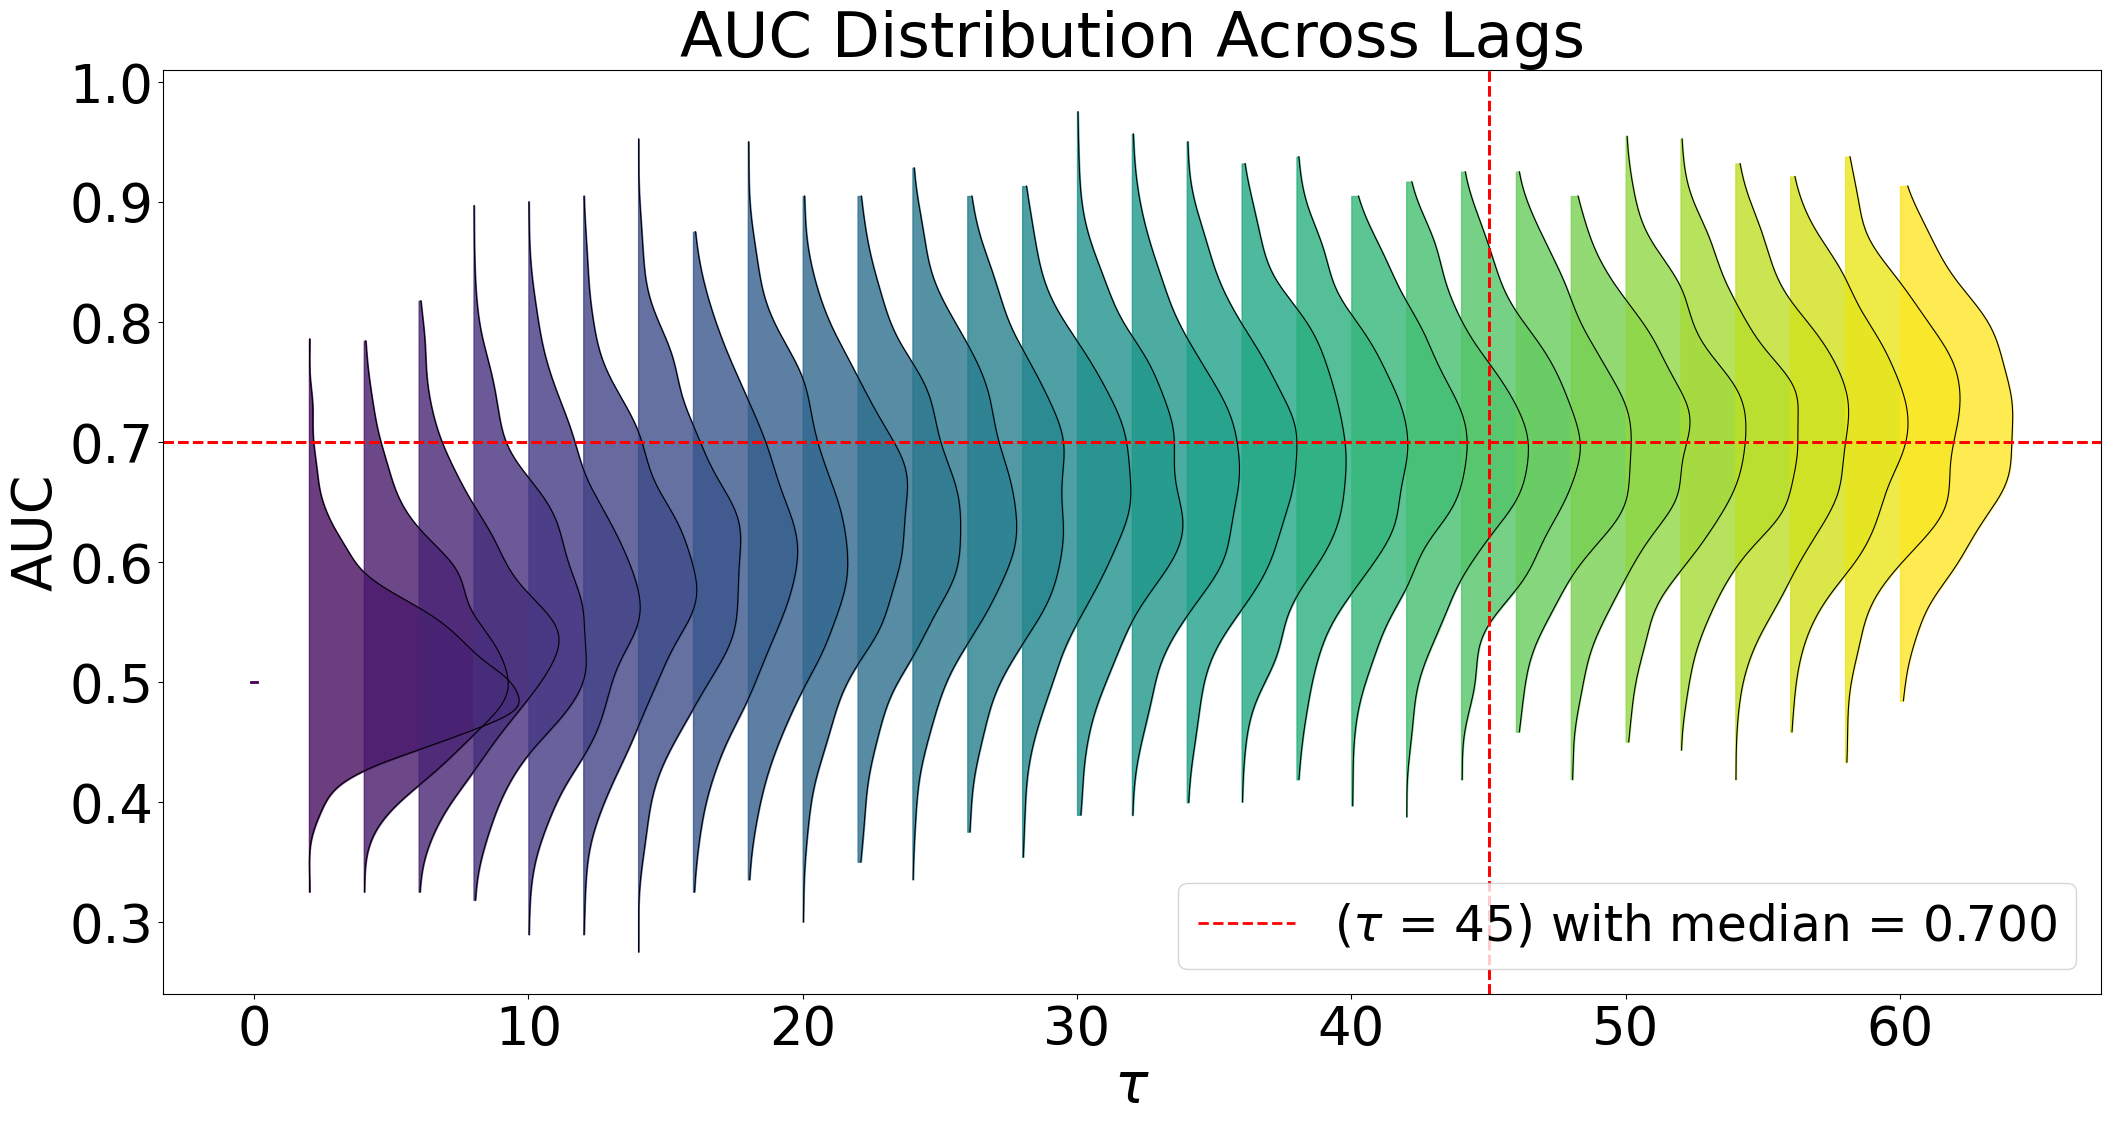

In [12]:
df = build_metric_df(all_results, "AUC")

plot_vertical_kde(
    df,
    metric="AUC",
    tau_step=2,
    tau_ref=45,
    axis_fontsize=40,
    tick_fontsize=38,
    title_fontsize=45,
    legend_fontsize=35,
    title=True
)


### FPR

<Axes: title={'center': 'FPR Distribution Across Lags'}, xlabel='$\\tau$', ylabel='FPR'>

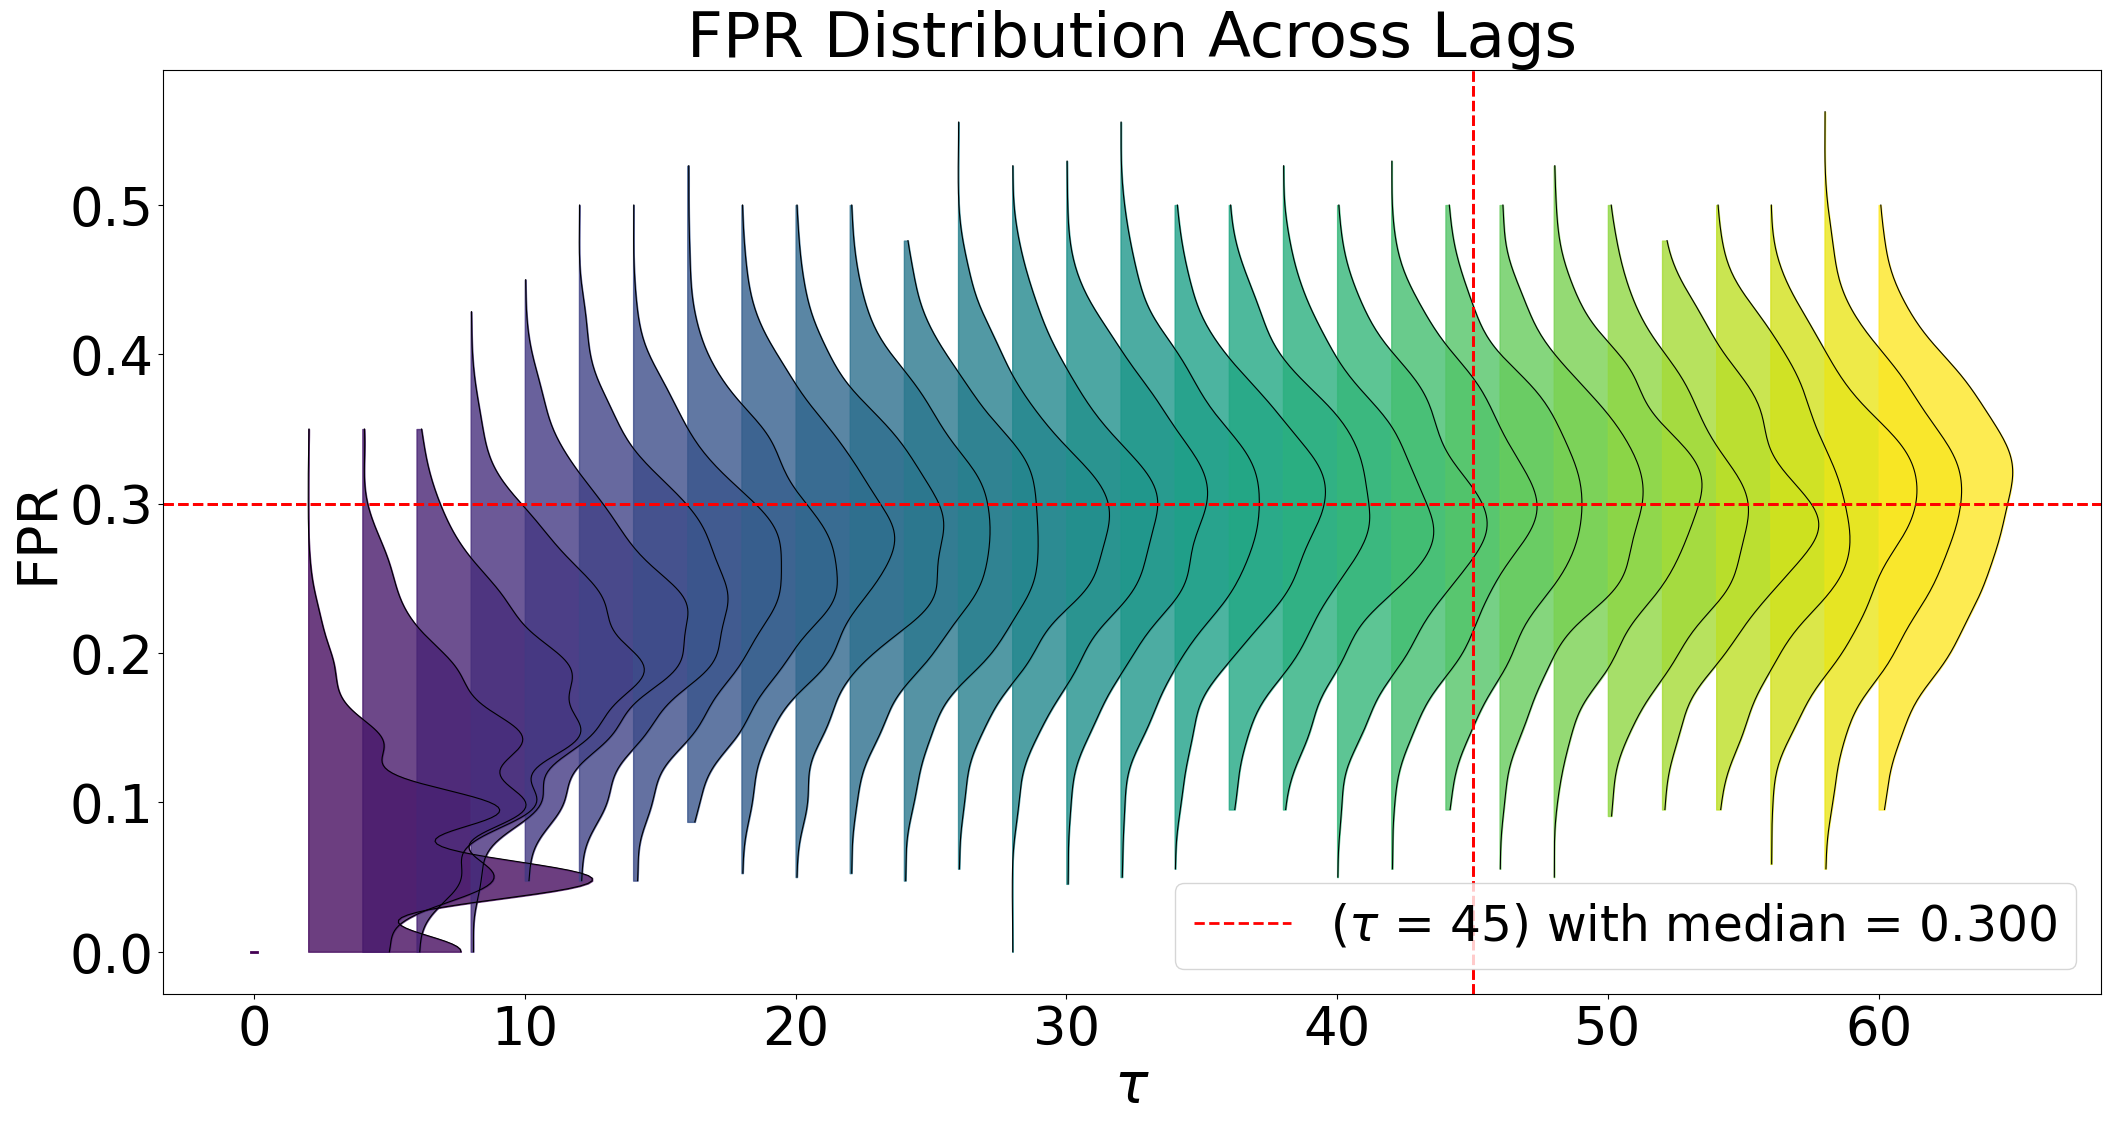

In [17]:
df = build_metric_df(all_results, "FPR")

plot_vertical_kde(
    df,
    metric="FPR",
    tau_step=2,
    tau_ref=45,
    axis_fontsize=40,
    tick_fontsize=38,
    title_fontsize=45,
    legend_fontsize=35,
    title=True
)


### TPR

<Axes: title={'center': 'TPR Distribution Across Lags'}, xlabel='$\\tau$', ylabel='TPR'>

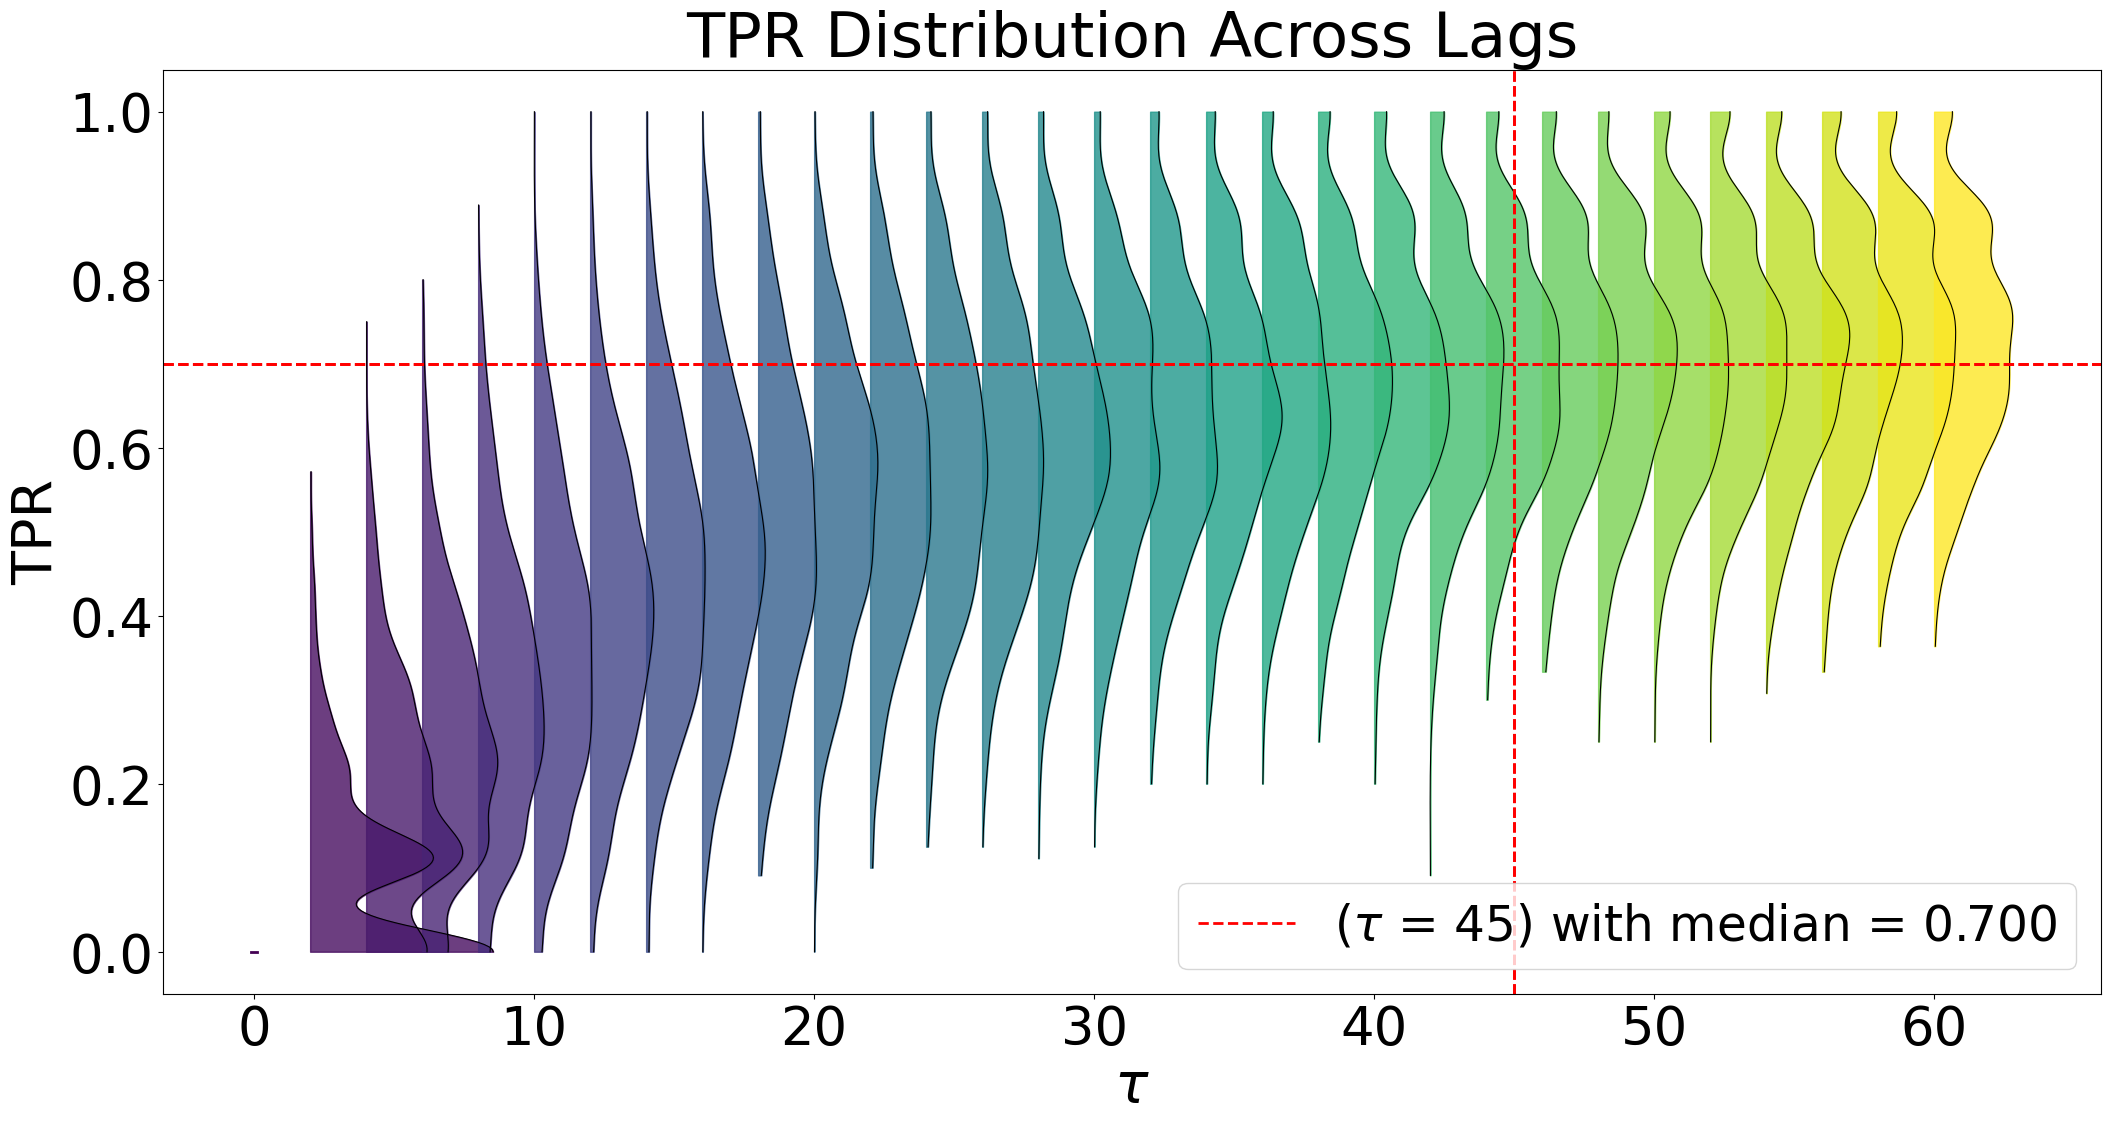

In [13]:
df = build_metric_df(all_results, "TPR")

plot_vertical_kde(
    df,
    metric="TPR",
    tau_step=2,
    tau_ref=45,
    axis_fontsize=40,
    tick_fontsize=38,
    title_fontsize=45,
    legend_fontsize=35,
    title=True
)


### F0.5

<Axes: title={'center': 'F0.5 Distribution Across Lags'}, xlabel='$\\tau$', ylabel='F0.5'>

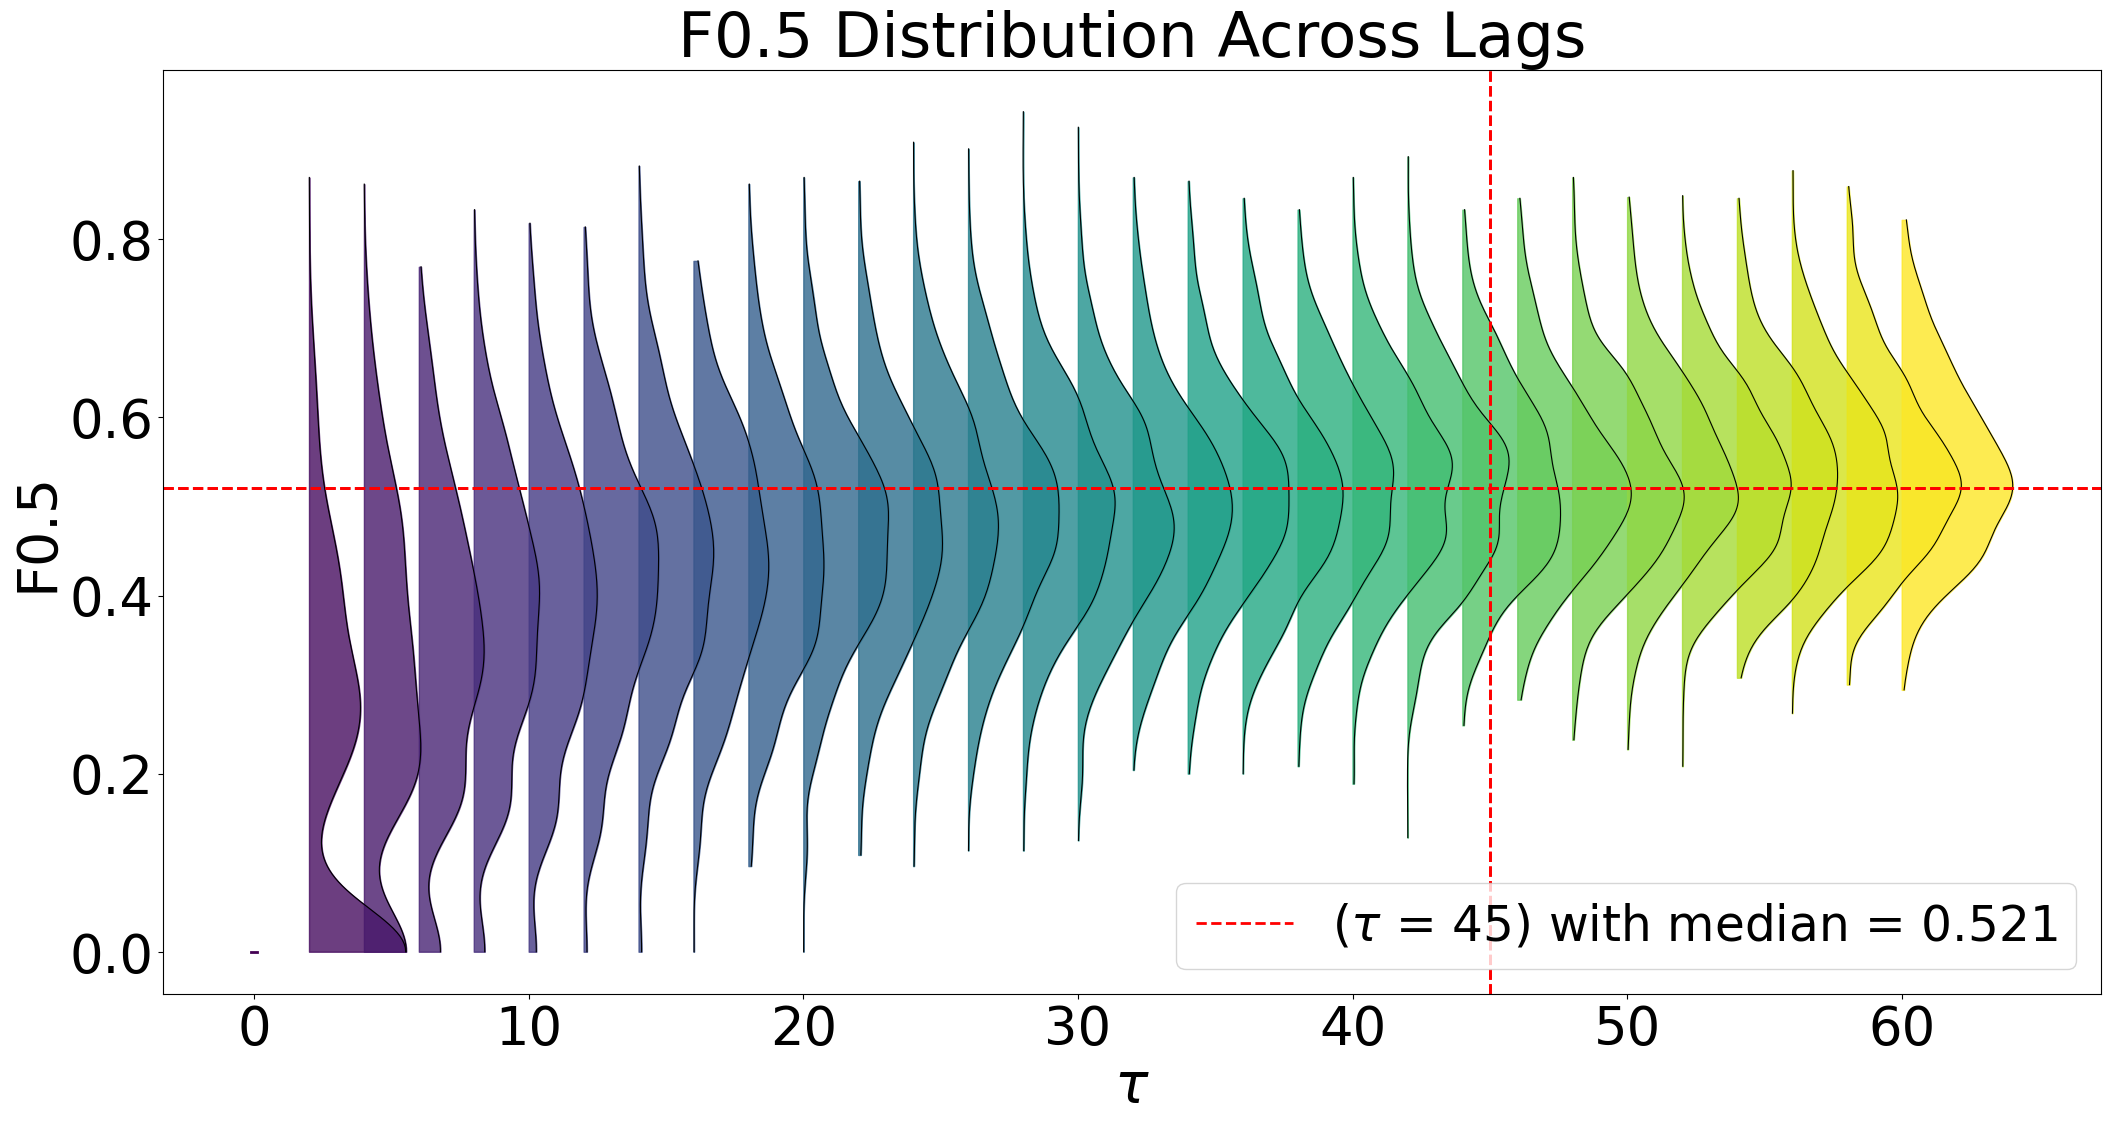

In [16]:
df = build_metric_df(all_results, "F0.5")

plot_vertical_kde(
    df,
    metric="F0.5",
    tau_step=2,
    tau_ref=45,
    axis_fontsize=40,
    tick_fontsize=38,
    title_fontsize=45,
    legend_fontsize=35,
    title=True
)


### SHD

<Axes: title={'center': 'SHD Distribution Across Lags'}, xlabel='$\\tau$', ylabel='SHD'>

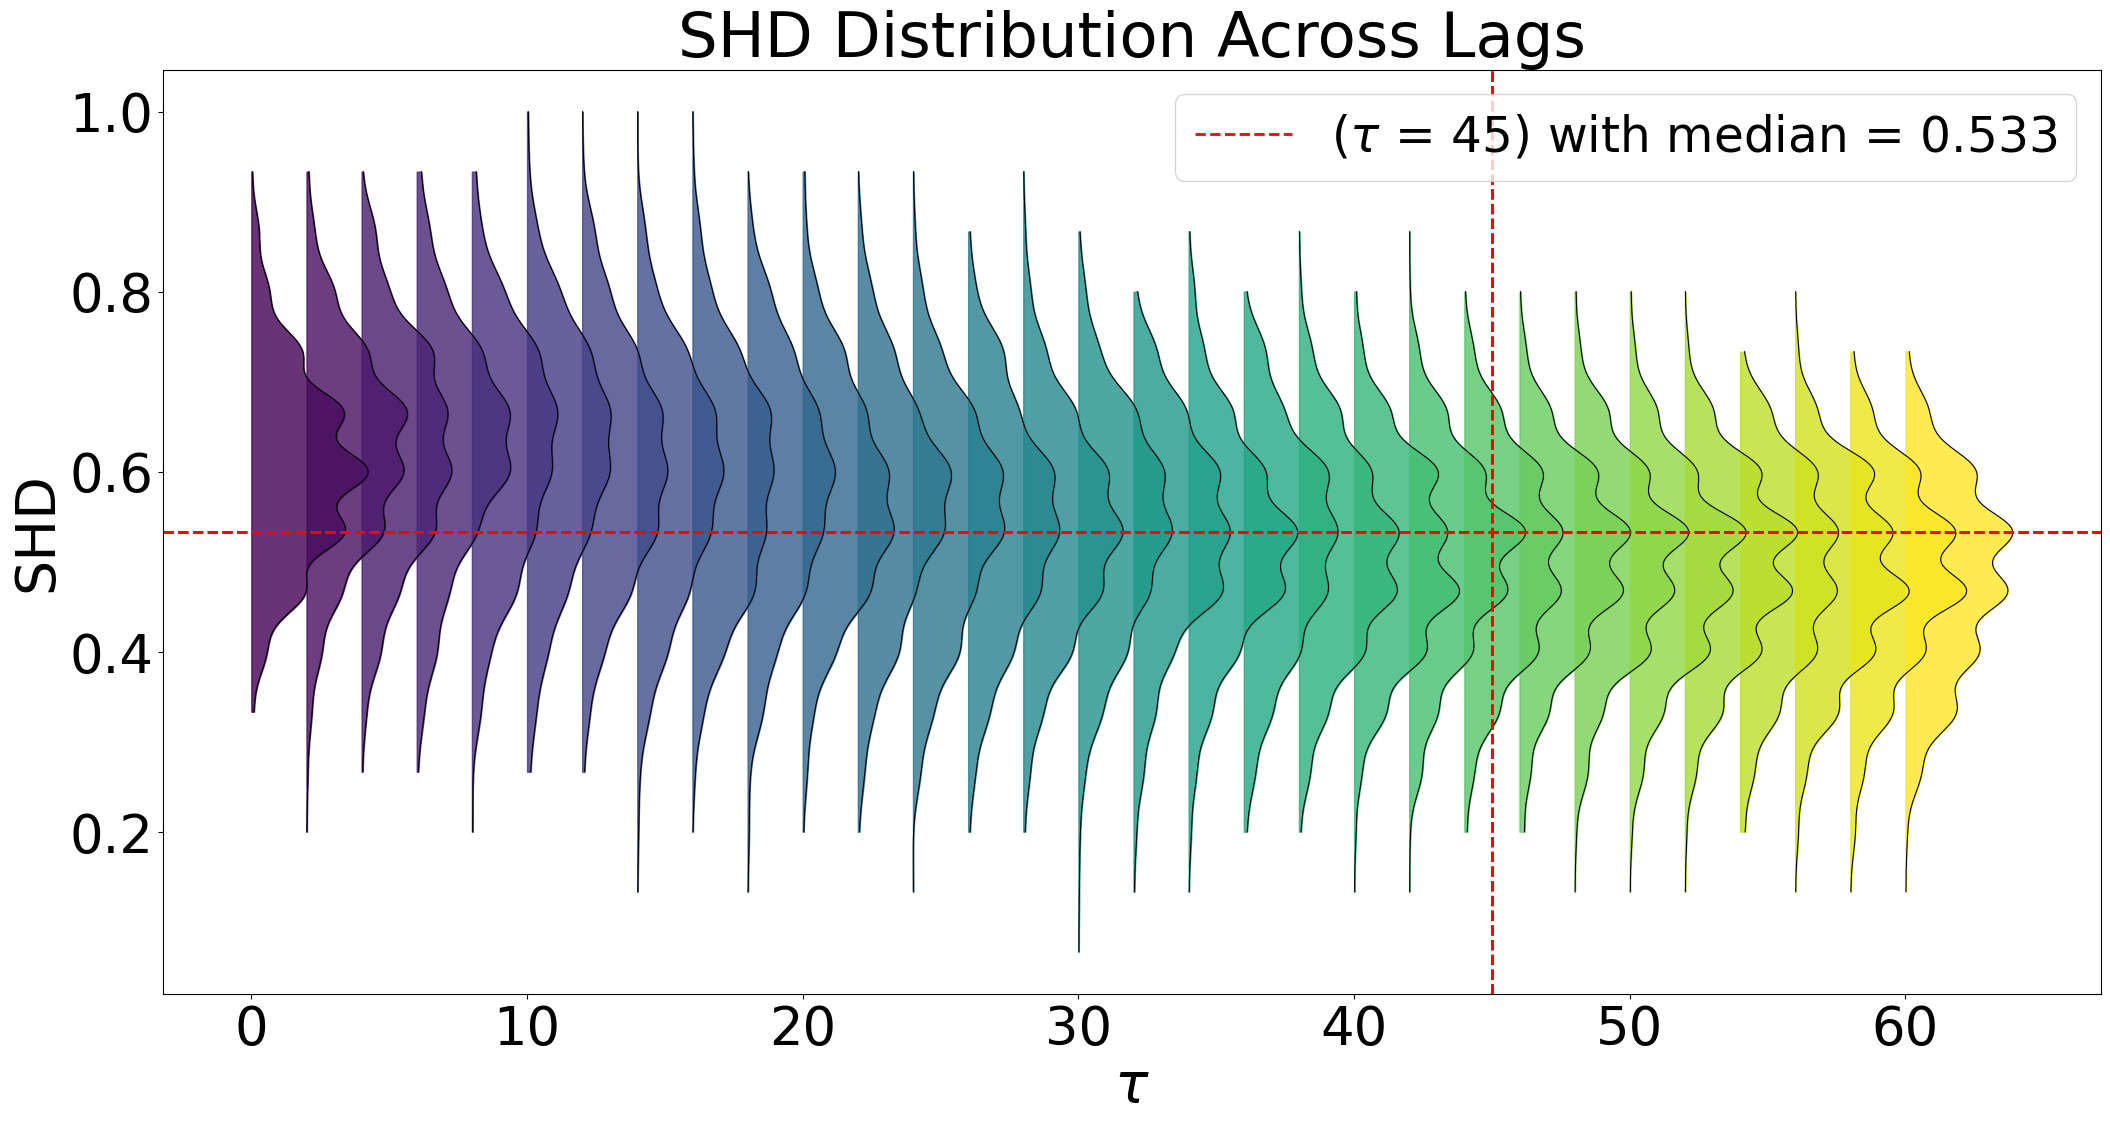

In [14]:
df = build_metric_df(all_results, "shd")

plot_vertical_kde(
    df,
    metric="shd",
    tau_step=2,
    tau_ref=45,
    axis_fontsize=40,
    tick_fontsize=38,
    title_fontsize=45,
    legend_fontsize=35,
    title=True
)


### SID

<Axes: title={'center': 'SID Distribution Across Lags'}, xlabel='$\\tau$', ylabel='SID'>

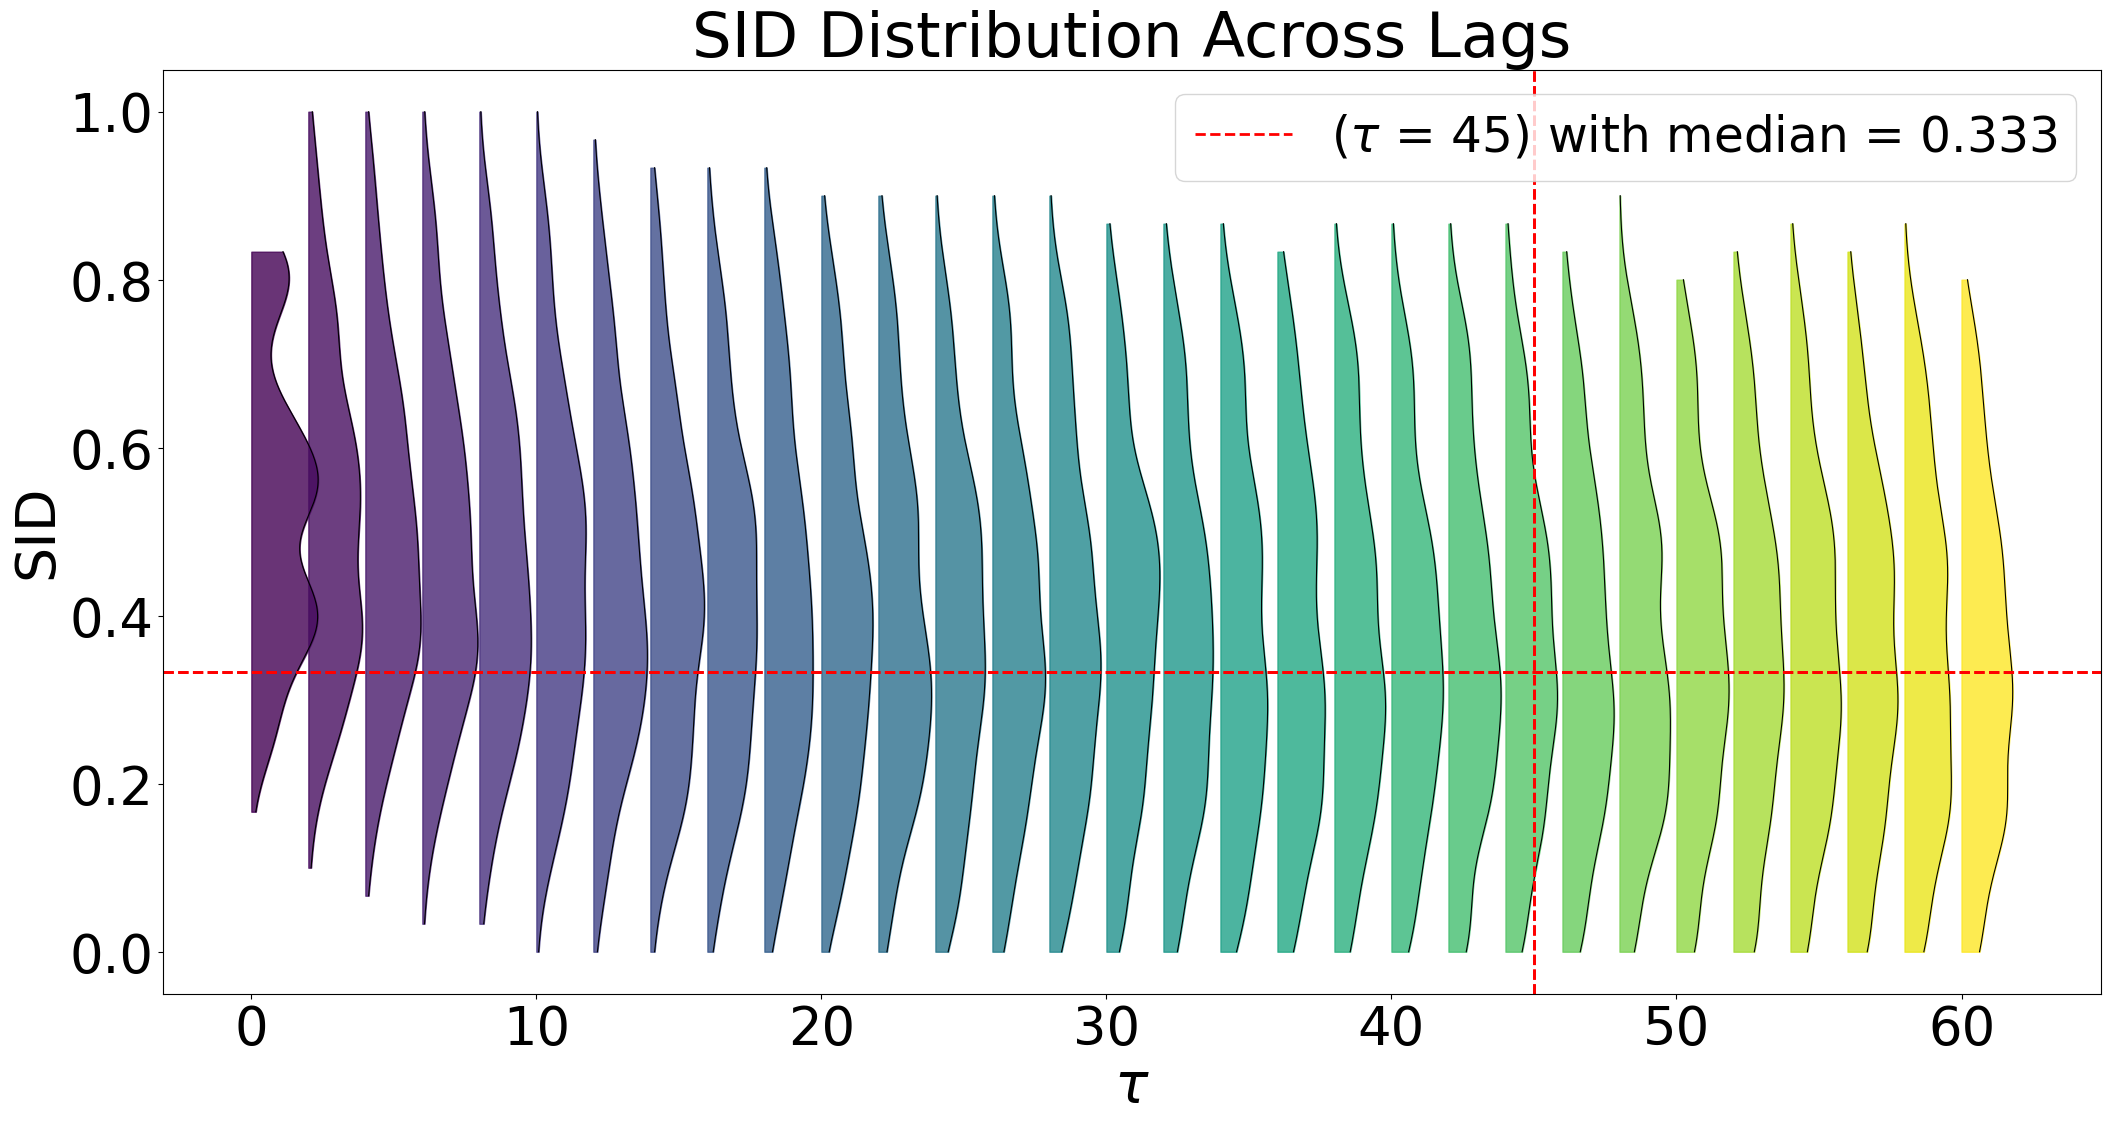

In [15]:
df = build_metric_df(all_results, "sid")

plot_vertical_kde(
    df,
    metric="sid",
    tau_step=2,
    tau_ref=45,
    axis_fontsize=40,
    tick_fontsize=38,
    title_fontsize=45,
    legend_fontsize=35,
    title=True
)
